# Test Recurrent Policy with Extreme Parameter Variation 

In [1]:
import numpy as np
import os,sys



sys.path.append('../../../RL_lib/Agents/PPO')
sys.path.append('../../../RL_lib/Utils')
sys.path.append('../../../RL_lib/Models')
sys.path.append('../../../Asteroid3dof_env')

%load_ext autoreload
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import os
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/briangaudet/Study/Subjects/MachineLearning/Projects/RL_Meta-Learning-master/Experiments/Asteroid_3DOF/Asteroid_PV_sphere


In [2]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Optimize Policy

3-dof dynamics model
lander model apf
Glideslope Constraint: delta =  3
Flat Constraint


<IPython.core.display.Javascript object>


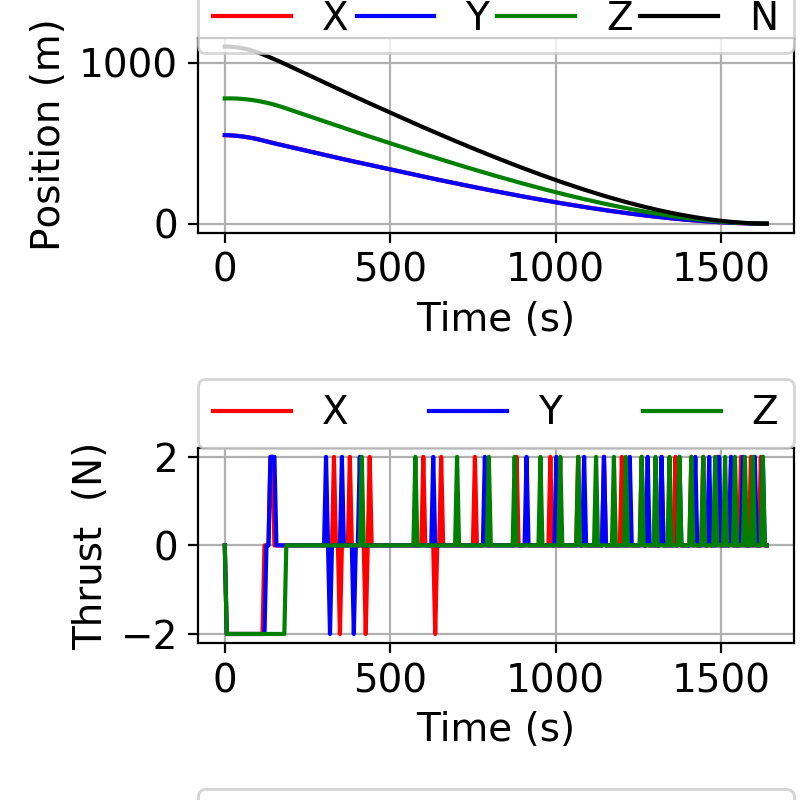

<IPython.core.display.Javascript object>


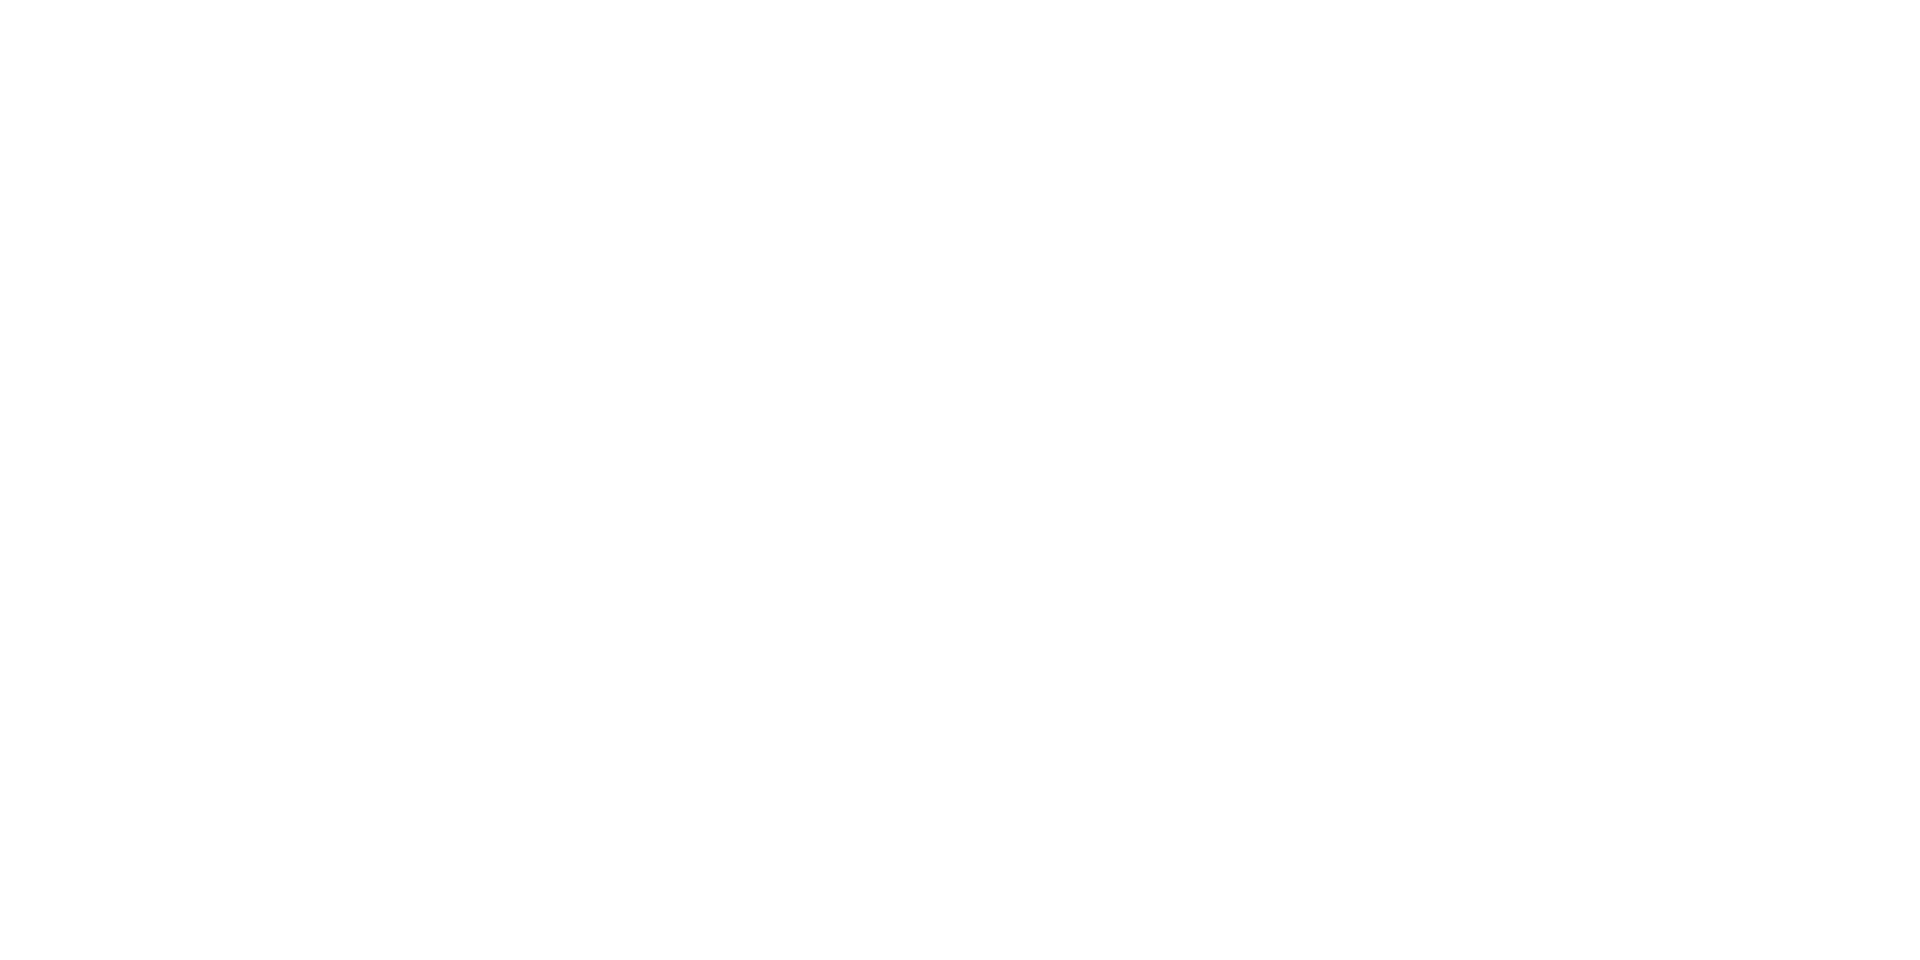

<IPython.core.display.Javascript object>


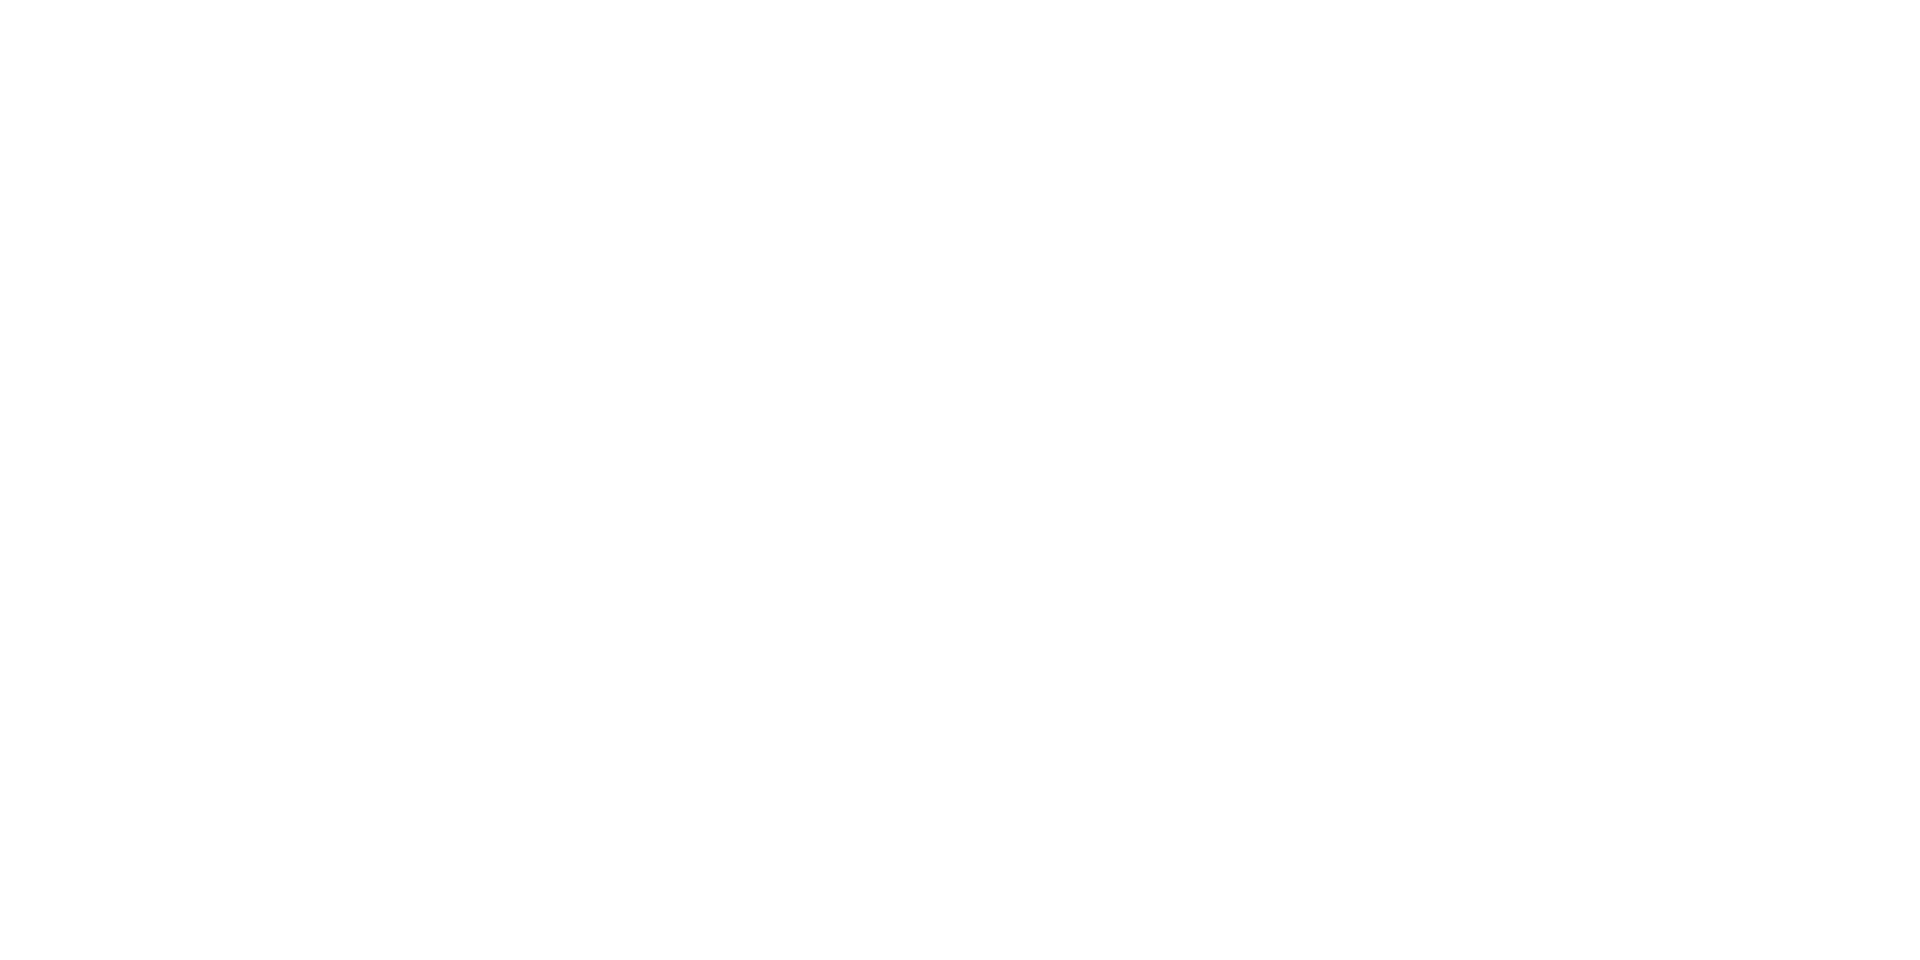

<IPython.core.display.Javascript object>


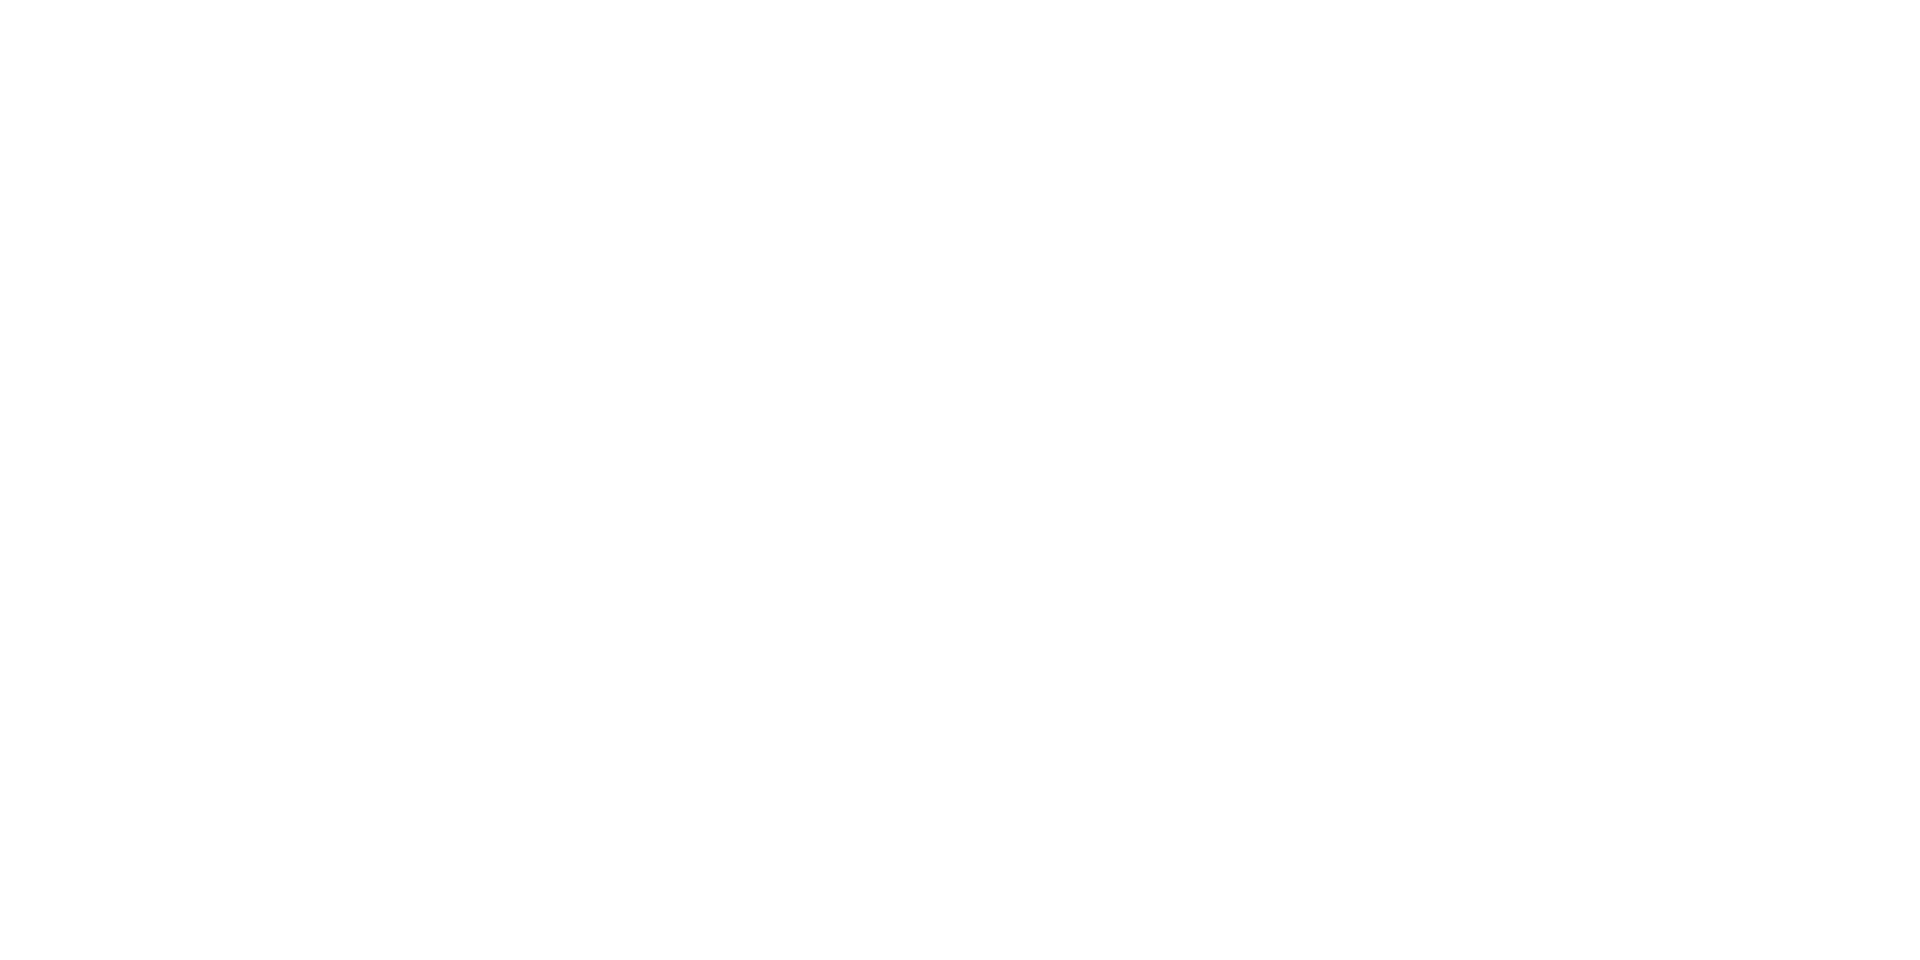

<IPython.core.display.Javascript object>


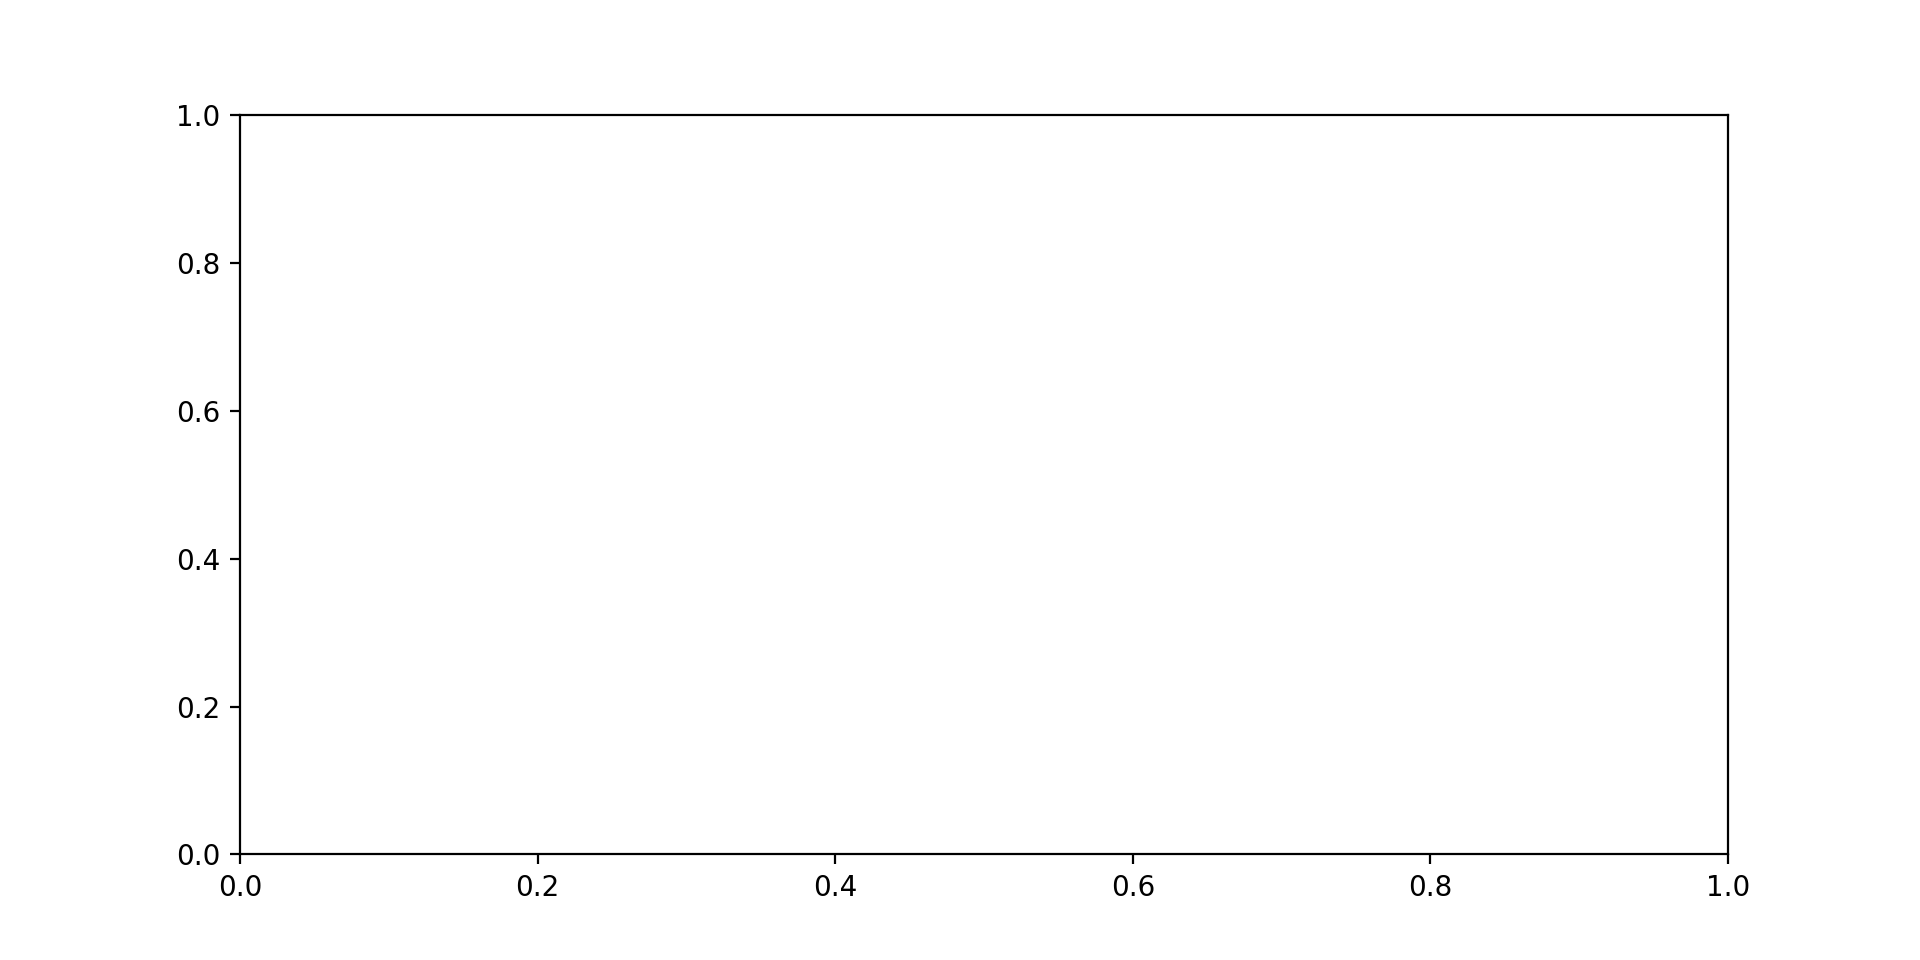

Lander Env
Landing_icgen:
    adjust_apf_v0               :  False
    w (min/max)                 :  (-0.001, -0.001, -0.001) (0.001, 0.001, 0.001)
 mass (min/max)                 :  450 500
  srp (min/max)                 :  (-1e-06, -1e-06, -1e-06) (1e-06, 1e-06, 1e-06)
M (min/max)                     :  (200000000000.0, 200000000000.0)
Position Theta                  :  (0.7853981633974483, 0.7853981633974483)
Position Phi                    :  (0.7853981633974483, 0.7853981633974483)
Policy with vectorized sample
	xn_init: layer  Linear(in_features=4, out_features=40, bias=True)
	xn_init: layer  GRUCell(40, 34)
	xn_init: layer  Linear(in_features=34, out_features=30, bias=True)
	xn_init: layer  Linear(in_features=30, out_features=3, bias=True)
Policy: recurrent steps > 1, disabling shuffle
[[-1.]
 [ 0.]
 [ 1.]]
	Test Mode:          False
	Clip Param:         0.1
	Shuffle :           False
	Max Grad Norm:      30
	Recurrent Steps:    60
	Rollout Limit:      1
Value Funtion
	xn_init

In [4]:
from env import Env
import env_utils as envu
from dynamics_model import Dynamics_model
from lander_model import Lander_model
from ic_gen_sphere import Landing_icgen
import rl_utils

from arch_policy_vf import Arch

from model import Model
from policy import Policy
from value_function import Value_function

import pcm_model_nets as model_nets
import policy_nets as policy_nets
import valfunc_nets as valfunc_nets

from agent import Agent


import torch.nn as nn

from flat_constraint import Flat_constraint
from glideslope_constraint import Glideslope_constraint
from reward_terminal_mdr import Reward


logger = rl_utils.Logger()
dynamics_model = Dynamics_model(landing_target=np.asarray([0., 0., 250.]))
lander_model = Lander_model(apf_tau1=300, apf_tau2=300, apf_vf1=-0.2, apf_vf2=-0.01, apf_atarg=20, apf_v0=1.0,
                           sensor_bias_range=(-0.0,0.0))
lander_model.min_thrust = 0
lander_model.max_thrust = 2
lander_model.get_state_agent = lander_model.get_state_agent2
lander_model.apf_pot = lander_model.apf_pot2
obs_dim = 4
act_dim = 3
recurrent_steps = 60

reward_object = Reward(landing_coeff=10.0, landing_rlimit=1, landing_vlimit=0.2, 
                       tracking_coeff=-1.00, fuel_coeff=-0.01, landing_gslimit=-1)

glideslope_constraint = Glideslope_constraint(gs_limit=-1.0)
shape_constraint = Flat_constraint()
env = Env(lander_model,dynamics_model,logger,
          reward_object=reward_object,
          glideslope_constraint=glideslope_constraint,
          shape_constraint=shape_constraint,
          tf_limit=5000.0,print_every=10,
           nav_period=6)

min_g   = -100e-6
max_g   = -1e-6
min_w   = -1.0e-3
max_w   =  1.0e-3
min_srp = -1e-6
max_srp =  1e-6
r = 1000
d = 100
env.ic_gen = Landing_icgen(adjust_apf_v0=False,
                            position_r=(1100,1100),
                            position_theta=(np.pi/4,np.pi/4),
                            position_phi=(np.pi/4,np.pi/4),
                            min_mass = 450, max_mass=500,
                            M=(20e10,20e10),
                            min_w=(min_w,min_w,min_w),  max_w=(max_w,max_w,max_w),
                            min_srp=(min_srp,min_srp,min_srp), max_srp=(max_srp,max_srp,max_srp))

                            
                          
                           
env.ic_gen.show()

arch = Arch()

policy = Policy(policy_nets.GRU(obs_dim, act_dim, recurrent_steps=recurrent_steps), shuffle=False,
                kl_targ=0.001,epochs=20, beta=0.1, servo_kl=True, max_grad_norm=30,
                init_func=rl_utils.xn_init, discretize=True)
value_function = Value_function(valfunc_nets.GRU(obs_dim, recurrent_steps=recurrent_steps), 
                                shuffle=False, batch_size=9999999, max_grad_norm=30)

agent = Agent(arch, policy, value_function, None, env, logger,
              policy_episodes=30, policy_steps=3000, gamma1=0.95, gamma2=0.995, lam=0.98, 
              recurrent_steps=recurrent_steps, monitor=env.rl_stats)
optimize=False
if optimize:
    agent.train(30000)
else:
    fname = "RNN_60step-sphere"
    policy.load_params(fname)
    value_function.load_params(fname)

# Test Policy 

In [5]:
print(1)
policy.test_mode=True  

env.test_policy_batch(agent,1000,print_every=100)

1
Dynamics: Max Disturbance (m/s^2):  [0.00020521 0.00032933 0.0002959 ] 0.00048797905725982745
Dynamics: Max w:                    [-5.43417269e-04 -6.10908814e-07 -3.93030086e-04]


KeyboardInterrupt: 

In [9]:
print(1)
policy.test_mode=True  
env.ic_gen.min_w=(-1e-3,-1e-3,1e-3)
env.ic_gen.min_w=(-0.0009,-0.0009,0.001)
env.ic_gen.min_w=(-1.1e-3,-1.1e-3,1.1e-3)
env.ic_gen.min_w=(-1.1e-6,-1.1e-6,1.1e-6)
v1 = -0.05
v2 = -0.05
v3 = 0.05
env.ic_gen.velocity_x=(v1,v1)
env.ic_gen.velocity_y=(v2,v2)
env.ic_gen.velocity_z=(v3,v3)
env.ic_gen.M = (20e10,20e10)
env.ic_gen.max_w = env.ic_gen.min_w
env.test_policy_batch(agent,1,print_every=1)
print(np.linalg.norm(dynamics_model.max_disturbance))

1

Cumulative Stats (mean,std,max,argmax)
thrust   |  0.83 |  1.22 |  0.00 |  3.46 |     0
glideslope | 3.916 |16.695 | 0.405 |100.000 |     0
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.016 |   0.000 |   0.016 |   0.016
norm_rf  |     0.1 |     0.0 |     0.1 |     0.1
position |    -0.1     0.0    -0.0 |     0.0     0.0     0.0 |    -0.1     0.0    -0.0 |    -0.1     0.0    -0.0
velocity |  -0.011  -0.005  -0.011 |   0.000   0.000   0.000 |  -0.011  -0.005  -0.011 |  -0.011  -0.005  -0.011
fuel     |  0.66 |  0.00 |  0.66 |  0.66
glideslope |  1.04 |  0.00 |  1.04 |  1.04

Initial Stats (mean,std,min,max)
norm_vf  |   0.087 |   0.000 |   0.087 |   0.087
norm_rf  |  1100.0 |     0.0 |  1100.0 |  1100.0
position |   550.0   550.0   777.8 |     0.0     0.0     0.0 |   550.0   550.0   777.8 |   550.0   550.0   777.8
velocity |  -0.050  -0.050   0.050 |   0.000   0.000   0.000 |  -0.050  -0.050   0.050 |  -0.050  -0.050   0.050
fuel  

<IPython.core.display.Javascript object>


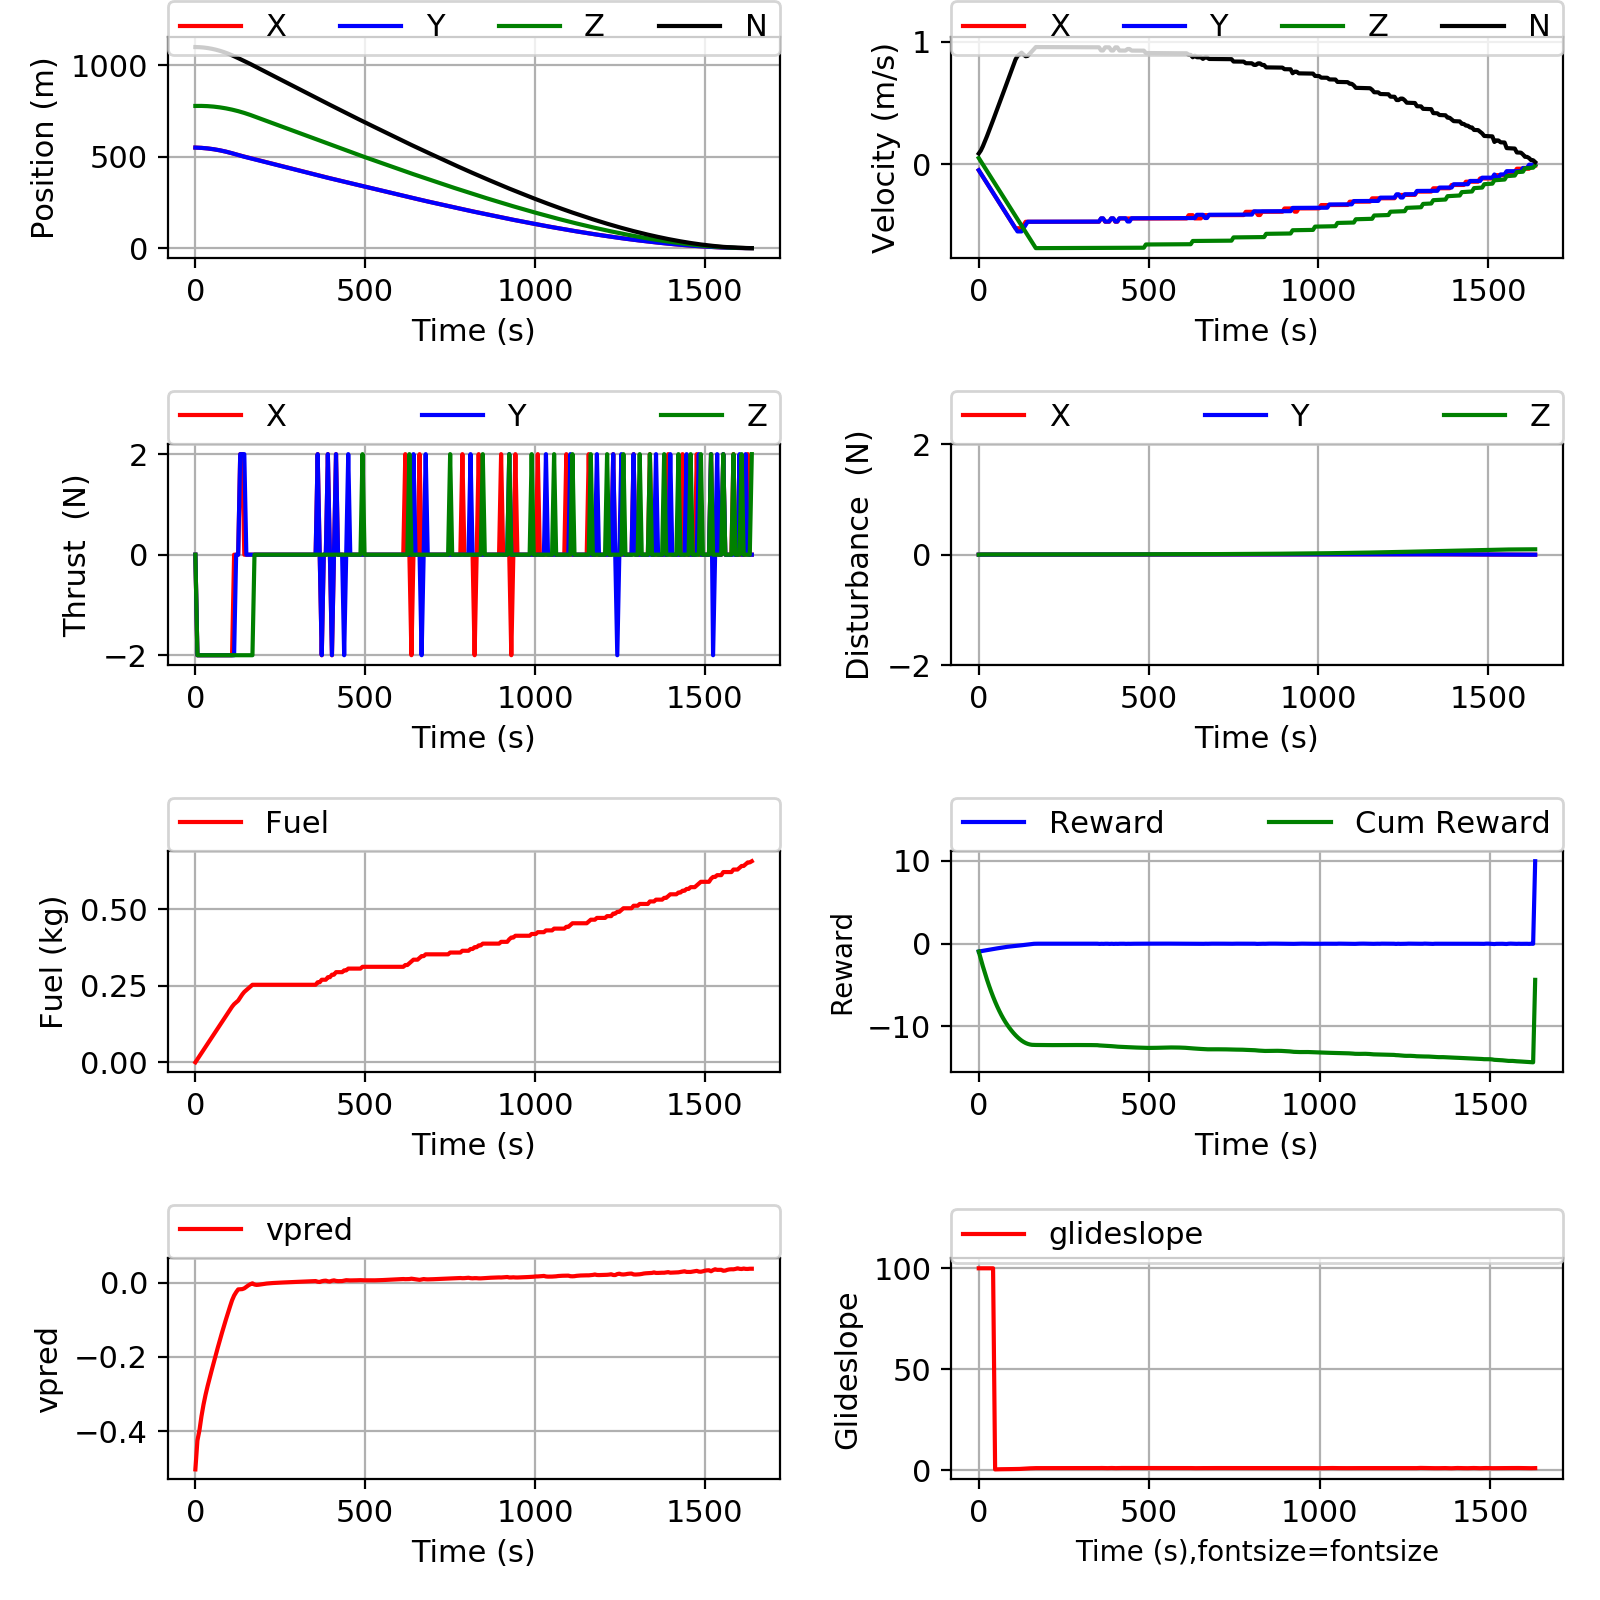

In [10]:
envu.render_traj(lander_model.trajectory_list[0],fontsize=11)

In [11]:
np.save('low_dist',lander_model.trajectory_list[0])

In [12]:
print(1)
policy.test_mode=True  
env.ic_gen.min_w=(-1.1e-3,-1.1e-3,1.1e-3)

v1 = -0.05
v2 = -0.05
v3 = 0.05
env.ic_gen.velocity_x=(v1,v1)
env.ic_gen.velocity_y=(v2,v2)
env.ic_gen.velocity_z=(v3,v3)
env.ic_gen.M = (20e10,20e10)
env.ic_gen.max_w = env.ic_gen.min_w
env.test_policy_batch(agent,1,print_every=1)
print(np.linalg.norm(dynamics_model.max_disturbance))

1

Cumulative Stats (mean,std,max,argmax)
thrust   |  2.11 |  1.11 |  0.00 |  3.46 |     0
glideslope |12.839 |31.665 | 0.046 |100.000 |     0
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.024 |   0.000 |   0.024 |   0.024
norm_rf  |     0.1 |     0.0 |     0.1 |     0.1
position |    -0.1    -0.0    -0.0 |     0.0     0.0     0.0 |    -0.1    -0.0    -0.0 |    -0.1    -0.0    -0.0
velocity |  -0.015   0.016  -0.011 |   0.000   0.000   0.000 |  -0.015   0.016  -0.011 |  -0.015   0.016  -0.011
fuel     |  2.01 |  0.00 |  2.01 |  2.01
glideslope |  1.80 |  0.00 |  1.80 |  1.80

Initial Stats (mean,std,min,max)
norm_vf  |   0.087 |   0.000 |   0.087 |   0.087
norm_rf  |  1100.0 |     0.0 |  1100.0 |  1100.0
position |   550.0   550.0   777.8 |     0.0     0.0     0.0 |   550.0   550.0   777.8 |   550.0   550.0   777.8
velocity |  -0.050  -0.050   0.050 |   0.000   0.000   0.000 |  -0.050  -0.050   0.050 |  -0.050  -0.050   0.050
fuel  

<IPython.core.display.Javascript object>


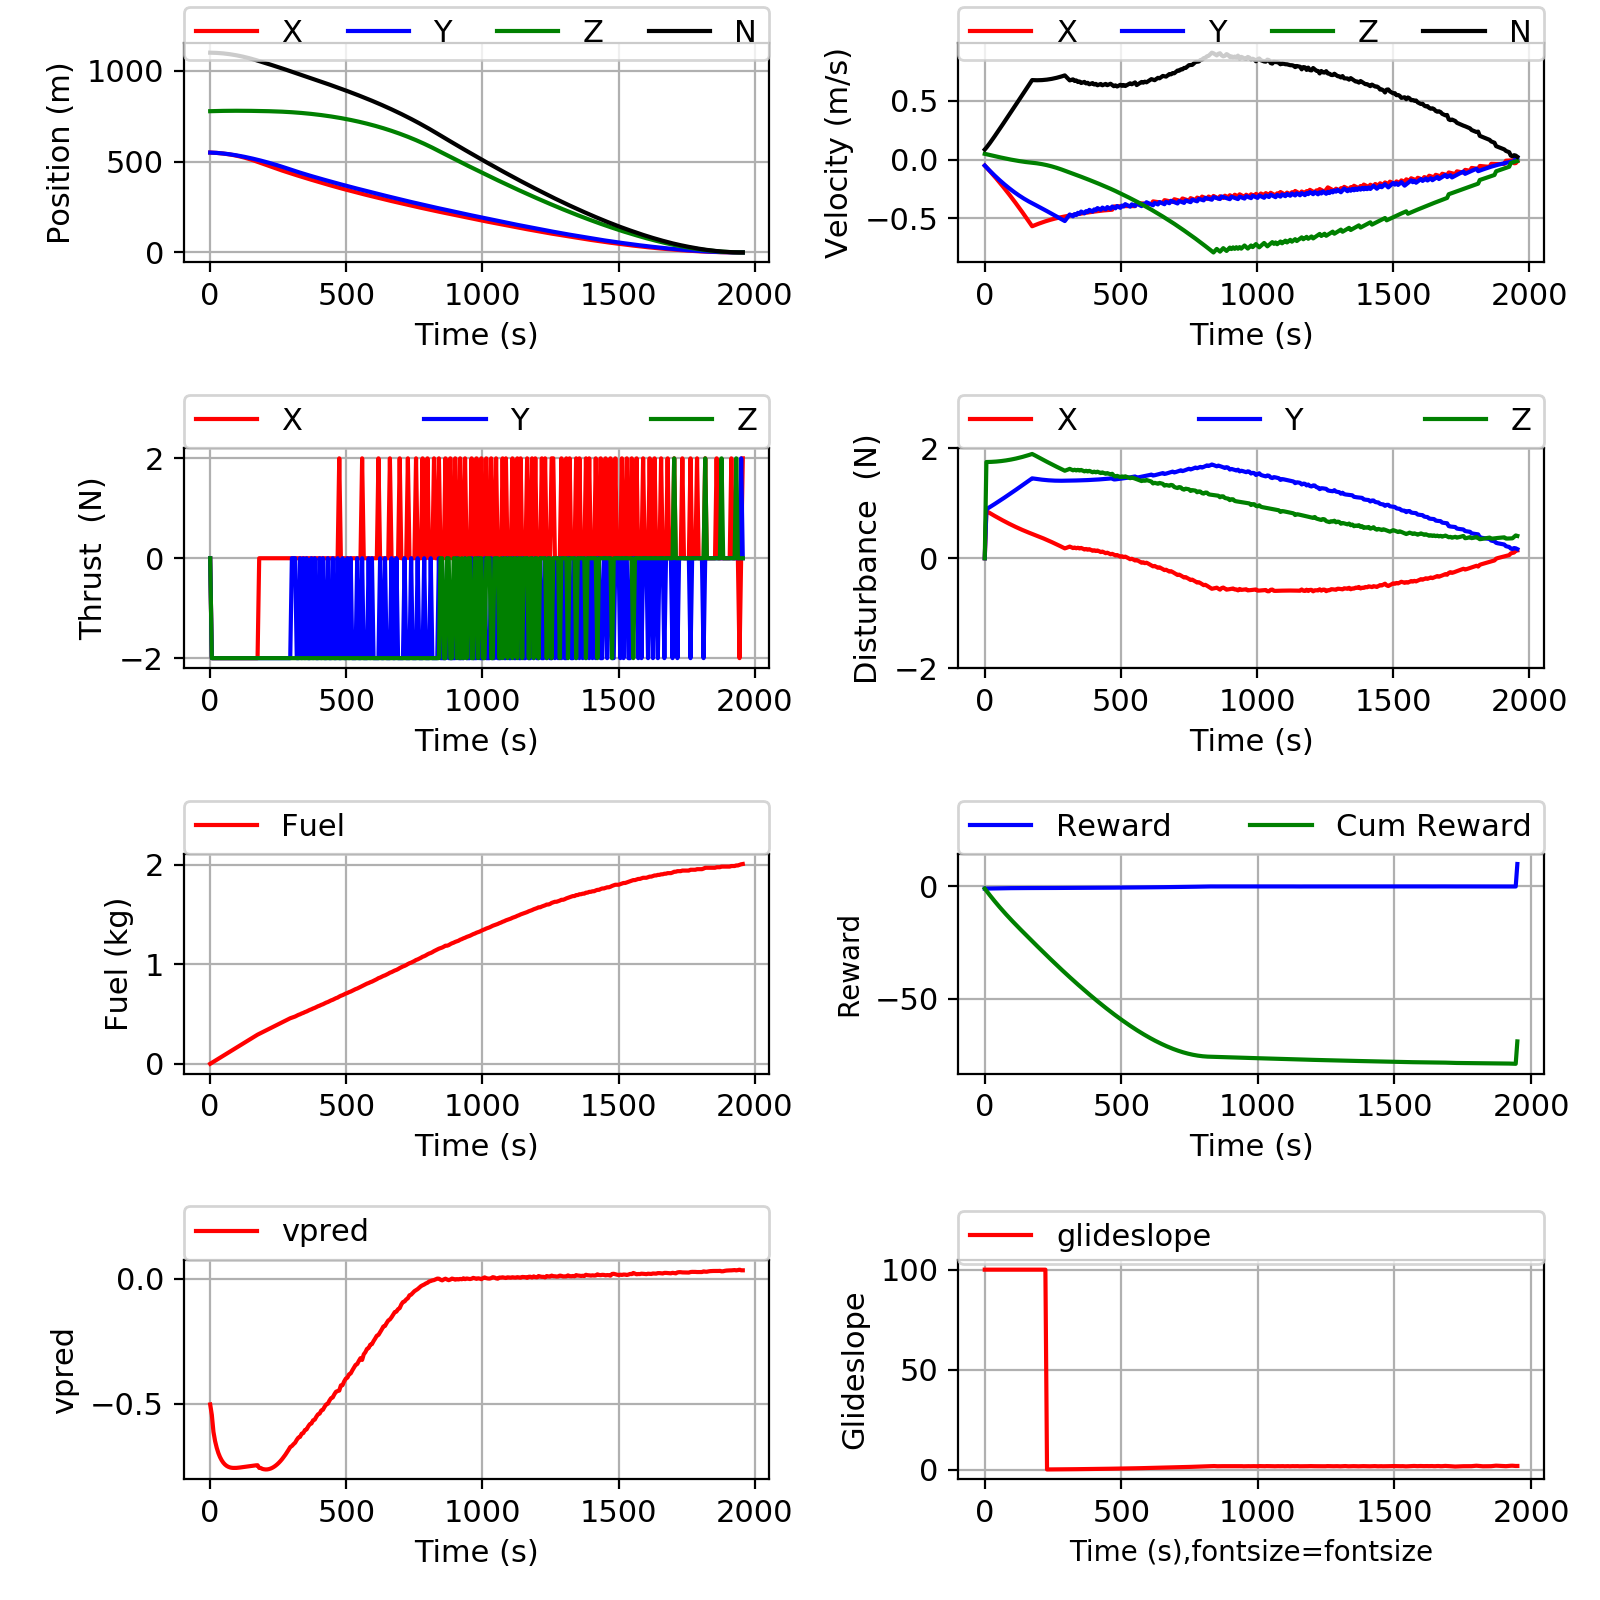

In [13]:
envu.render_traj(lander_model.trajectory_list[0],fontsize=11)

In [14]:
np.save('high_dist',lander_model.trajectory_list[0])